In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
%matplotlib inline

In [2]:
trainingAirBnb = pd.read_csv("Data/train.csv")

testAirBnb = pd.read_csv("Data/test.csv")

In [3]:
trainingAirBnb['city'].value_counts()

NYC        32349
LA         22453
SF          6434
DC          5688
Chicago     3719
Boston      3468
Name: city, dtype: int64

Data Cleaninig

In [4]:
PropertyMap = {'Apartment':['Condominium','Timeshare','Loft','Serviced apartment','Guesthouse'],
         'House':['Vacation home','Villa','Townhouse','In-law','Casa particular','Cabin','Bungalow','Castle'],
         'Hostel':['Dorm','Hostel'],
         'Hotel':['Boutique hotel','Bed & Breakfast','Guest suite'],
         'Other':['Island','Yurt','Hut','Chalet','Treehouse','Tipi','Cave','Train','Parking Space','Lighthouse',
                 'Tent','Boat','Camper/RV','Earth House']}
         
PropertyTypeMap = {i : k for k, v in PropertyMap.items() for i in v}


def extract_list(s):
    for c in ['{','}','"']:
        s=s.replace(c,'')
    for c in ['/',':',' ','-','.','&',')','(','\'']:
        s=s.replace(c,'_')
    s=s.replace('matress','mattress')
    return s.split(',')

def preprocessing(pdf, test=False):
    data = pdf.copy()
    if not test:
        data=data[data['log_price']!=0]
        data['price']=np.exp(data['log_price'])
#         
    data.drop(columns=['id','last_review', 'name','host_has_profile_pic',
                       'host_since', 'description', 'first_review','thumbnail_url','zipcode'
                        , 'neighbourhood','bathrooms','bed_type',
                      'beds','bedrooms',
                      'host_identity_verified','host_response_rate','instant_bookable'],inplace =True)
    data['property_type']=data['property_type'].replace(PropertyTypeMap)
    data['room_type']=data['room_type'].str.replace(' ','_')
    data['amenities']=data['amenities'].apply(extract_list).str.join(' ')
    data['cleaning_fee']=data['cleaning_fee'].replace({True:1, False:0})
    data.fillna(0,inplace=True)
    return data

def get_lat_long(df):
    return df[['latitude','longitude']]

    
    

The decision to remove most of the features above, was to avoid colinearity or because there was not enough evidence (In analysis phase) to prove any correlation with price. 

In [5]:
train_pp_df = preprocessing(trainingAirBnb)

train_pp_df.head()

log_price property_type        room_type  \
0   5.010635     Apartment  Entire_home/apt   
1   5.129899     Apartment  Entire_home/apt   
2   4.976734     Apartment  Entire_home/apt   
3   6.620073         House  Entire_home/apt   
4   4.744932     Apartment  Entire_home/apt   

                                           amenities  accommodates  \
0  Wireless_Internet Air_conditioning Kitchen Hea...             3   
1  Wireless_Internet Air_conditioning Kitchen Hea...             7   
2  TV Cable_TV Wireless_Internet Air_conditioning...             5   
3  TV Cable_TV Internet Wireless_Internet Kitchen...             4   
4  TV Internet Wireless_Internet Air_conditioning...             2   

  cancellation_policy  cleaning_fee city   latitude   longitude  \
0              strict             1  NYC  40.696524  -73.991617   
1              strict             1  NYC  40.766115  -73.989040   
2            moderate             1  NYC  40.808110  -73.943756   
3            flexible             1   SF  37.772004 -122.431619   
4            moderate             1   DC  38.925627  -77.034596   

   number_of_reviews  review_scores_rating  price  
0                  2                 100.0  150.0  
1                  6                  93.0  169.0  
2                 10                  92.0  145.0  
3                  0                   0.0  750.0  
4                  4                  40.0  115.0

# The model will consist of:

- Unchanged Features <br>
UN_feature = ['accommodates','number_of_reviews']
<br>
<br>
- One hot encoding Features <br>
OHE_Features = ['room_type']
<br>
<br>
-Progressive categorical feature (Box plot sugest that higher price correlates with this policy) <br>
Categorical = ['cancellation_policy']
<br>
<br>
- Other tranformations  <br>
HET_Features = ['latitude','longitude','amenities']

## Necesary functions and class for pipelines

In [6]:


def cancelation_cat(df):
    data = df.copy()
    CancelationMap = {'strict': 0, 'flexible':1,
                  'moderate':2, 'super_strict_30':3, 'super_strict_60':4, 'long_term':3}
    data['cancellation_policy'] = data['cancellation_policy'].map(CancelationMap)
    data['cancellation_policy'] = data['cancellation_policy'].astype('category')
    return data

def get_col_no_change(df):
    col_no_change = ['accommodates','number_of_reviews','review_scores_rating']
    return df[col_no_change]

def get_lat_lon(df):
    return df['latitude','longitude']

In [7]:
class MyTransformer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer. (KNNR doesn't have fit_tranform)'''

    def __init__(self, model):
        self.model=model
        pass

    def fit(self, X, y=None):
        self.model.fit(X, y)
        return self

    def transform(self, X):
        return pd.DataFrame(self.model.predict(X))

## Pipeline for Feature tranformation
####  - One Hot encoder for Categorical Variables
#### - Using Neighborhood will result in to many features in the model, we can create a single feature using KNNR   with latitude and longitude
#### - Amenities affect the pricing of the unit, This feature is tranformed using countVectorize then SVD to reduce the dimensions and finally a KNNR to further reduce. 


In [8]:

column_enca = ColumnTransformer ( transformers=[
    ('cancelation_cat', FunctionTransformer(func=cancelation_cat, validate=False), ['cancellation_policy'] ) ]
)

column_enc = ColumnTransformer( transformers=[
                            ('OHE', OneHotEncoder(sparse=False), ['room_type',
                                                                                'city'] ) ])


ktest = KNNR()
Negihbors_lat_long = MyTransformer(ktest)



column_lat_long = ColumnTransformer(transformers=[
                ( 'KNNLatLon', Negihbors_lat_long ,['latitude','longitude'] ) ] )


Amenities_vec_transf = ColumnTransformer(transformers=[('amenities', CountVectorizer(),'amenities')])

Amenities_svd = TruncatedSVD()

Amenities_KN = MyTransformer(KNNR())


Amenities_pipeline = Pipeline(steps=[('Amenities_vec_transf', Amenities_vec_transf)
                           , ('AmSVD', Amenities_svd )
                        #    ,('MyTransformer_am', Amenities_KN) 
                                    ])

Transformer_get_columns = Pipeline (
    [('Select_col_no_change', FunctionTransformer(func=get_col_no_change, validate=False))]
)

FeatureUnionTransformer = FeatureUnion([
                                        ('Transformer_get_columns',Transformer_get_columns)
                                        ,('column_enca',         column_enca)
                                        ,('column_enc',    column_enc)
                                        ,('column_lat_long',         column_lat_long)
                                        ,('Amenities_pipeline',      Amenities_pipeline)
                                       ])


In [9]:
X = train_pp_df.drop('log_price',axis='columns')
y = train_pp_df['log_price']

#### Selecting 3 different models (Linear Regression, RandomForest, KNN) and defining parameters to adjust

In [12]:
# min_df=0.5

Gral_params = {
    'FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df':[0.2,0.5],
    'FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors':[170,200],
    'FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components':[2,5,7]
#     'FeatureUnionTransformer__Amenities_pipeline__MyTransformer_am__model__n_neighbors':[7]

    
}

pipe_LR= Pipeline([('FeatureUnionTransformer', FeatureUnionTransformer),
                        ('Linear_regressor', LinearRegression ())
                       ])


RFR_params = {    

    'RTreesR__min_samples_split':[70,90],
    'RTreesR__n_estimators':[350],
    'FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df':[0.2,0.5],
    'FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors':[170,200],
    'FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components':[2,5,7]
#     'FeatureUnionTransformer__Amenities_pipeline__MyTransformer_am__model__n_neighbors':[7]

}

pipe_RFR= Pipeline([('FeatureUnionTransformer', FeatureUnionTransformer),
                        ('RTreesR', RandomForestRegressor())
                       ])


# n_neighbors = 200
knn_params = { 'KNNR__n_neighbors': [20,50],
    'FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df':[0.2,0.5],
    'FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors':[170,200],
    'FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components':[2,5,7]
#     'FeatureUnionTransformer__Amenities_pipeline__MyTransformer_am__model__n_neighbors':[7]

             }

 

pipe_KNNR = Pipeline([('FeatureUnionTransformer', FeatureUnionTransformer),
                        ('KNNR', KNNR())
                       ])

XGRF_params = { 'XGBRF__n_estimators': [500,1000],
                 'XGBRF__learning_rate': [0.01, 0.3],
    'FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df':[0.2],
    'FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors':[170,200],
    'FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components':[5]

             }

pipe_XGRFR = Pipeline([('FeatureUnionTransformer', FeatureUnionTransformer),
                        ('XGBRF', XGBRFRegressor())
                       ])

models = {pipe_XGRFR:XGRF_params, pipe_LR:Gral_params,pipe_KNNR:knn_params}
# 

#### Evaluate all models and select parameters that result in a lower RMSE

In [13]:
models_compete = {}
Feature_params = {}
Model_params = {}

for model, params in models.items():
#     model_name = type(model)
#     print( str(model))
    if params:
        grid_CV = GridSearchCV(estimator = model, param_grid = params,
                          cv = 2, scoring='neg_root_mean_squared_error',verbose=2)
        grid_CV.fit(X, y)
        best_rmse = -1 * grid_CV.best_score_
        best_param = grid_CV.best_params_
#         model_name = model.named_steps
        models_compete[best_rmse] = best_param, model
    else:
        best_rmse = -1 * cross_val_score(pipe_LR,X,y,cv=2,
                                 scoring='neg_root_mean_squared_error',n_jobs = 4).mean()
        best_param = 'na'

        models_compete[i] = [best_rmse, best_param]


        
        
        
    

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.2, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170, XGBRF__learning_rate=0.01, XGBRF__n_estimators=500; total time=  11.9s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.2, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170, XGBRF__learning_rate=0.01, XGBRF__n_estimators=500; total time=  11.0s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.2, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170, XGBRF__learning_rate=0.01, XGBRF__n_estimators=1000; total time=  

[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.5, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170; total time=   2.7s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.5, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170; total time=   2.7s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.5, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=200; total time=   2.9s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.5, FeatureUnionTransformer__column_lat_long__KN

[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.2, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170, KNNR__n_neighbors=50; total time=  36.3s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.2, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=170, KNNR__n_neighbors=50; total time=  36.1s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.2, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=200, KNNR__n_neighbors=20; total time=  36.4s
[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=5, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__a

[CV] END FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components=7, FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df=0.5, FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors=200, KNNR__n_neighbors=50; total time=  39.4s


In [14]:
best_rmse = min(models_compete)
best_parms = models_compete[min(models_compete)][0]
best_model = models_compete[min(models_compete)][1]
print(f'best rmmse; {best_rmse}')
print(f'best parameters; {best_parms}')
print(f'Best model; {best_model.steps[1][0]}')


best rmmse; 0.4318074001765526
best parameters; {'FeatureUnionTransformer__Amenities_pipeline__AmSVD__n_components': 7, 'FeatureUnionTransformer__Amenities_pipeline__Amenities_vec_transf__amenities__min_df': 0.2, 'FeatureUnionTransformer__column_lat_long__KNNLatLon__model__n_neighbors': 170}
Best model; Linear_regressor


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
best_model.set_params(**best_parms)
best_model.fit(X_train, y_train)

Pipeline(steps=[('FeatureUnionTransformer',
                 FeatureUnion(transformer_list=[('Transformer_get_columns',
                                                 Pipeline(steps=[('Select_col_no_change',
                                                                  FunctionTransformer(func=<function get_col_no_change at 0x00000157821DC820>))])),
                                                ('column_enca',
                                                 ColumnTransformer(transformers=[('cancelation_cat',
                                                                                  FunctionTransformer(func=<function cancelation_cat at 0x00000157821D...
                                                 ColumnTransformer(transformers=[('KNNLatLon',
                                                                                  MyTransformer(model=KNeighborsRegressor(n_neighbors=170)),
                                                                                  ['lat

In [16]:
from math import sqrt
best_y_train_ = best_model.predict(X_train)
best_y_test_ = best_model.predict(X_test)

print("Train (RMSE): %.4f" % sqrt(np.mean((best_y_train_ - y_train) ** 2)))
print("Train MAE: %.2f" % np.mean(np.absolute(best_y_train_ - y_train)))


print("Validation (RMSE): %.4f" % sqrt(np.mean((best_y_test_ - y_test) ** 2)))
print("Validation MAE: %.2f" % np.mean(np.absolute(best_y_test_ - y_test)))

Train (RMSE): 0.4267
Train MAE: 0.31
Validation (RMSE): 0.4338
Validation MAE: 0.32


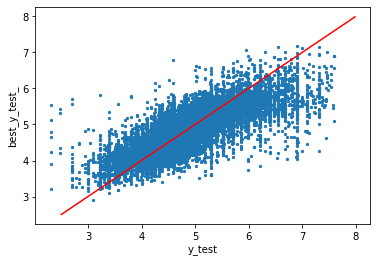

In [17]:
plt.scatter(y_test,best_y_test_,s = 5 )
XX = np.arange(2.5, 8, 0.01)
yy = XX
plt.xlabel('y_test')
plt.ylabel('best_y_test_')
plt.plot(XX, yy, '-r' )
plt.show()